In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdmolops, AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys


from scipy.stats import pearsonr


# sklearn ML models
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import  LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

from sklearn.model_selection import KFold

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'


/Users/liugrp_m/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# experimental values

In [2]:
df = pd.read_csv('../01-database-preprocessing-1203dp-to-1115dp/raw/atom_number_wH_sort_1115-backbone-correction-newSMILES.csv')
df.head()

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122


In [3]:
df_exp = df['bandgap(eV)']
df_exp

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1110    1.68
1111    1.65
1112    1.66
1113    1.52
1114    1.73
Name: bandgap(eV), Length: 1115, dtype: float64

# DFT descriptors

### B3LYP

In [4]:
df = pd.read_csv('./DFT/scf-6-31gs.csv')
df_b3lyp = df[['HOMO-LUMO(eV)']]
df_b3lyp

,HOMO-LUMO(eV)
0,2.78726
1,2.72032
2,3.19979
3,2.69964
4,2.66372
...,...
1110,1.93038
1111,1.93065
1112,2.04439
1113,1.94561


### wB97XD

In [5]:
df = pd.read_csv('./DFT/wb97xd-6-31gs.csv')
df_wb97xd = df[['HOMO-LUMO(eV)']]
df_wb97xd

,HOMO-LUMO(eV)
0,6.07168
1,6.01263
2,6.61237
3,5.97943
4,5.93861
...,...
1110,5.04254
1111,5.03302
1112,5.21343
1113,5.03547


### CAM-B3LYP

In [6]:
df = pd.read_csv('./DFT/camb3lyp-6-31gs.csv')
df_camb3lyp = df[['HOMO-LUMO(eV)']]
df_camb3lyp

,HOMO-LUMO(eV)
0,4.98376
1,4.92009
2,5.50024
3,4.88798
4,4.84880
...,...
1110,3.97123
1111,3.95354
1112,4.12334
1113,3.96361


### PBEPBE

In [7]:
df = pd.read_csv('./DFT/pbepbe-6-31gs.csv')
df_pbepbe = df[['HOMO-LUMO(eV)']]
df_pbepbe

,HOMO-LUMO(eV)
0,1.76303
1,1.68792
2,2.08358
3,1.68302
4,1.65500
...,...
1110,1.02424
1111,1.03757
1112,1.11594
1113,1.04383


In [8]:
xc_func_list = ['B3LYP', '$\omega$B97XD', 'CAM-B3LYP', 'PBE']
feature = pd.concat([df_b3lyp, df_wb97xd, df_camb3lyp, df_pbepbe], axis = 1)
feature.columns = xc_func_list
feature

,B3LYP,$\omega$B97XD,CAM-B3LYP,PBE
0,2.78726,6.07168,4.98376,1.76303
1,2.72032,6.01263,4.92009,1.68792
2,3.19979,6.61237,5.50024,2.08358
3,2.69964,5.97943,4.88798,1.68302
4,2.66372,5.93861,4.84880,1.65500
...,...,...,...,...
1110,1.93038,5.04254,3.97123,1.02424
1111,1.93065,5.03302,3.95354,1.03757
1112,2.04439,5.21343,4.12334,1.11594
1113,1.94561,5.03547,3.96361,1.04383


In [9]:
feature[np.isnan(feature).any(axis=1)==True]


,B3LYP,$\omega$B97XD,CAM-B3LYP,PBE
691,NaN,NaN,NaN,NaN


# drop sp3-N polymers + donor-692

In [11]:
sp3_N_list = [  24,   44,  191,  201,  206,  209,  251,  317,  318,  332,  374,
             381,  388,  454,  913,  931,  936, 1006]
drop_list = sp3_N_list+[691]
print('Total data points: ', 1115-len(drop_list))

Total data points:  1096


In [12]:
feature = feature[~feature.index.isin(drop_list)].reset_index(drop=True)
df_exp = df_exp[~df_exp.index.isin(drop_list)].reset_index(drop=True)


## Pearson correlation

In [13]:
feature.corr()

,B3LYP,$\omega$B97XD,CAM-B3LYP,PBE
B3LYP,1.000000,0.989747,0.992570,0.986613
$\omega$B97XD,0.989747,1.000000,0.999555,0.960033
CAM-B3LYP,0.992570,0.999555,1.000000,0.964564
PBE,0.986613,0.960033,0.964564,1.000000


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'B3LYP'),
  Text(0, 1.5, '$\\omega$B97XD'),
  Text(0, 2.5, 'CAM-B3LYP'),
  Text(0, 3.5, 'PBE')])

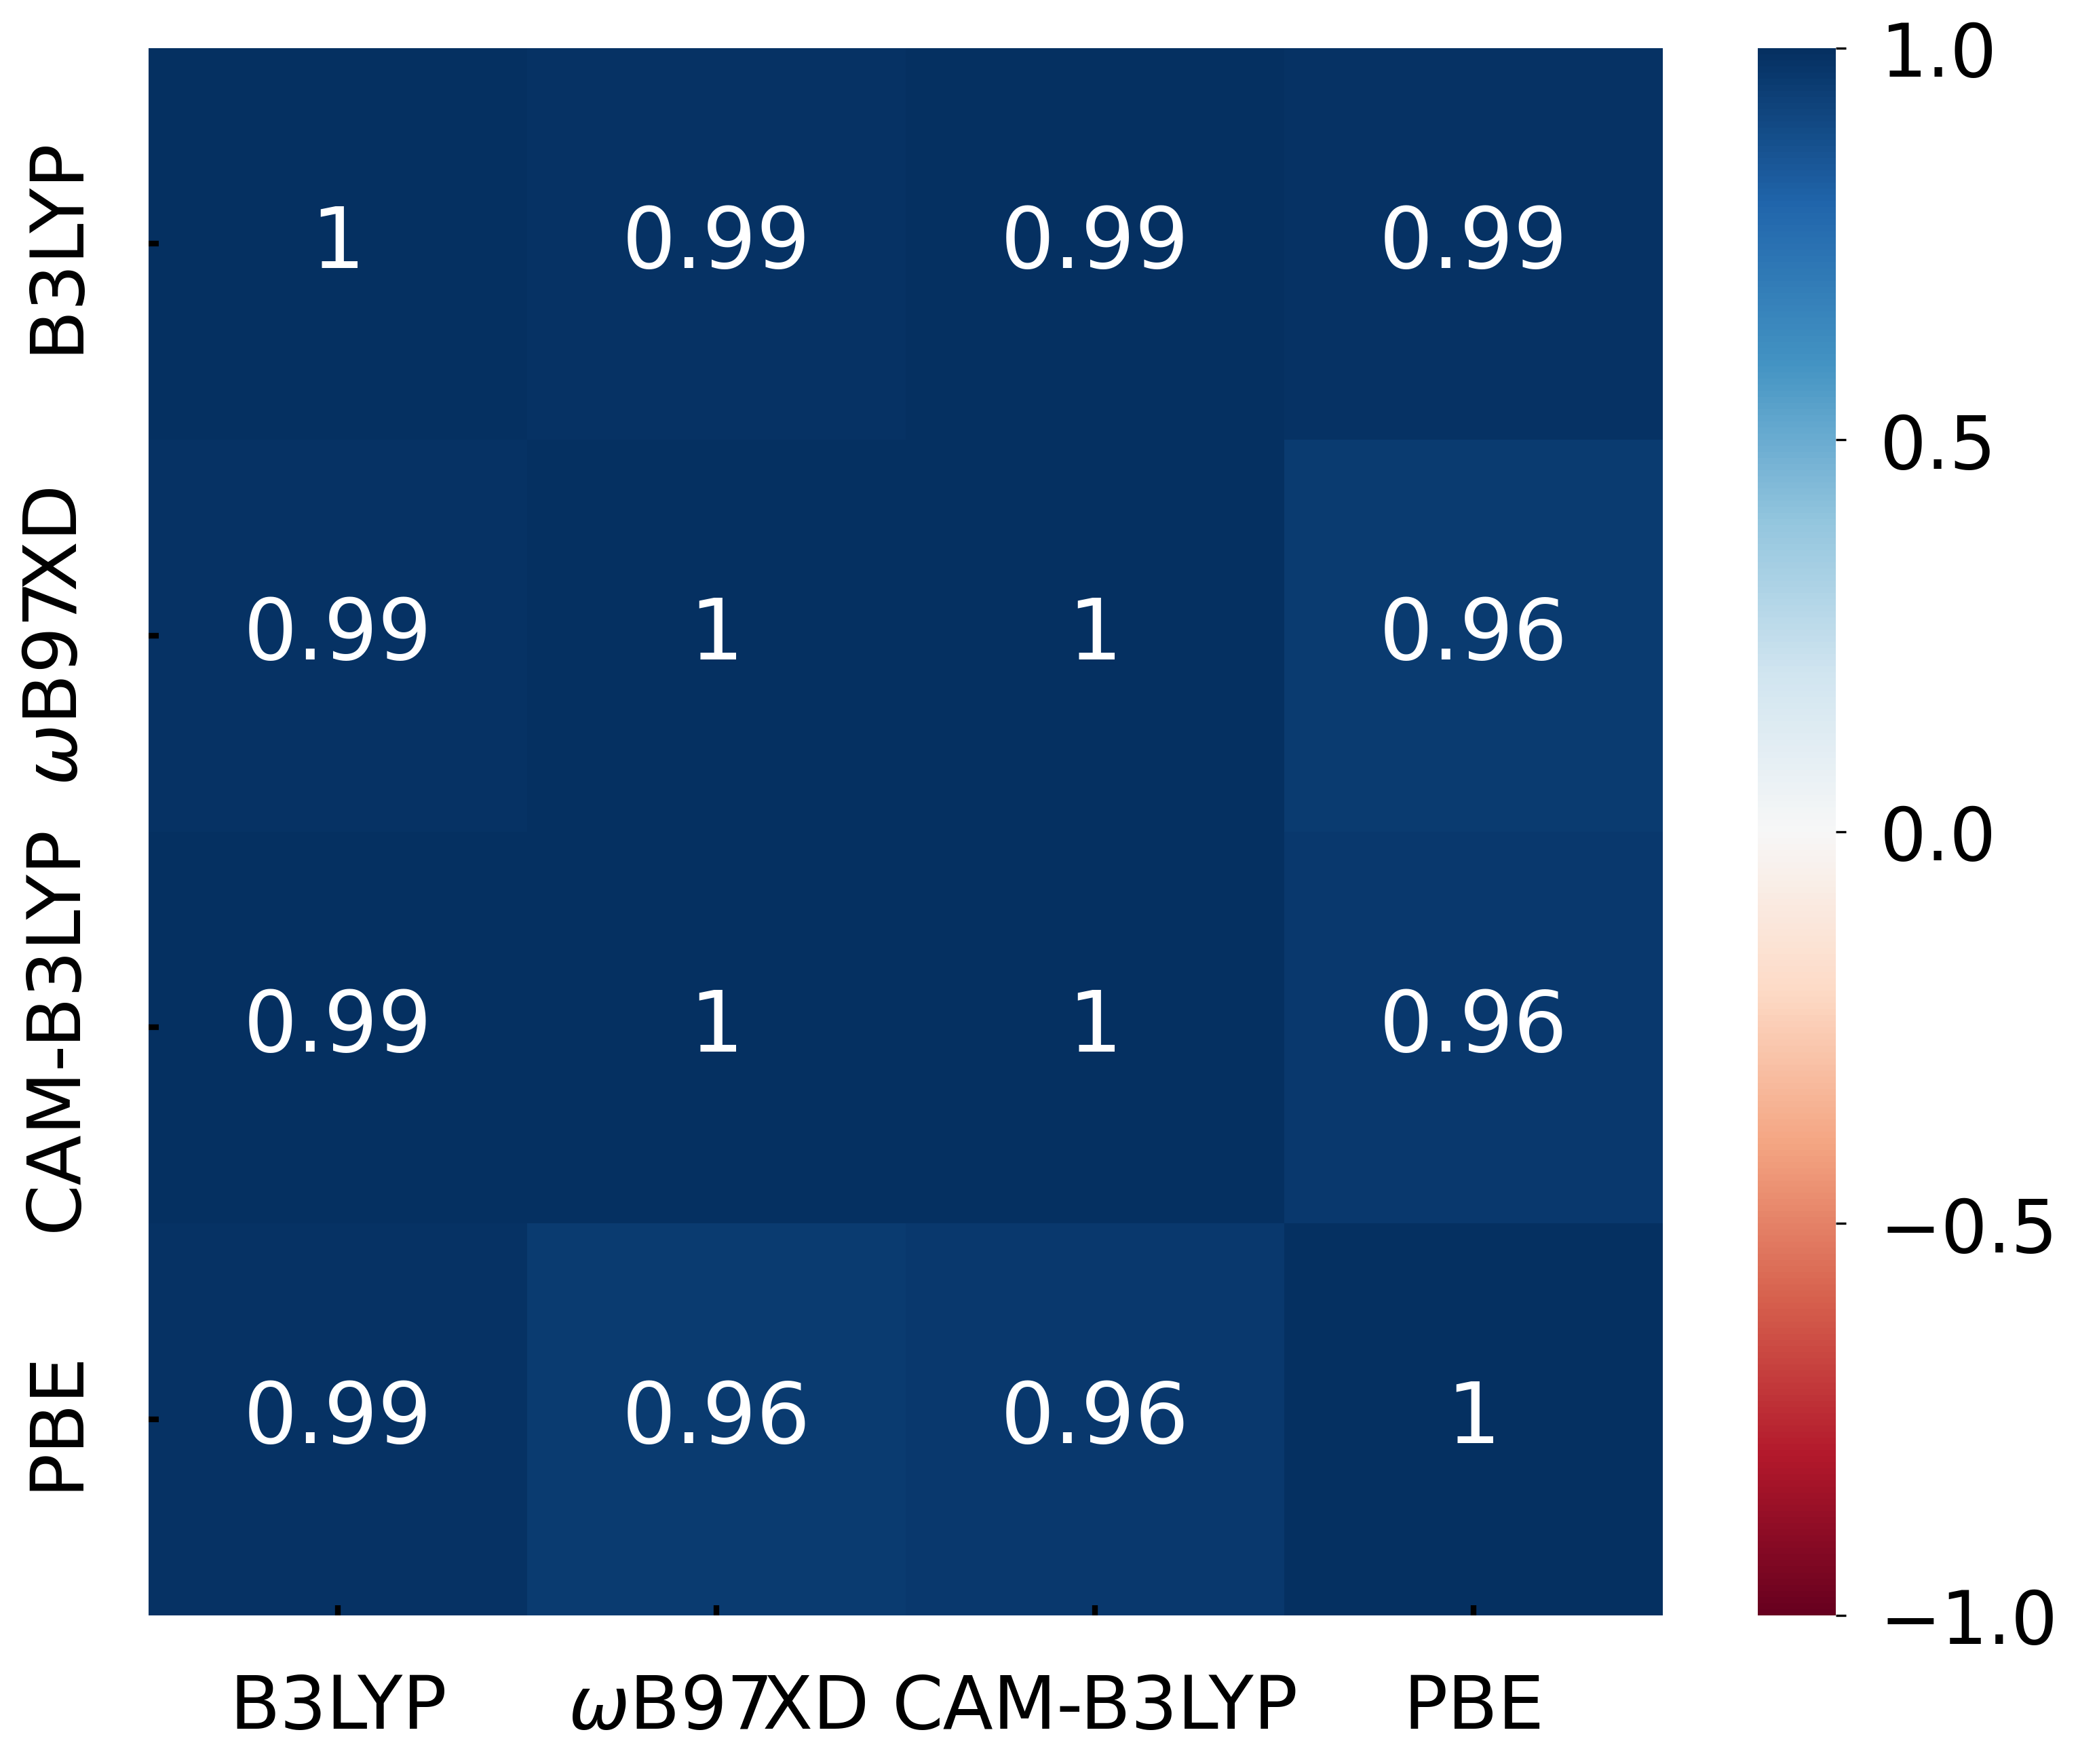

In [14]:
fig, ax = plt.subplots(figsize=(12,10), dpi=300)
heatmap = sns.heatmap(feature.corr(), cmap="RdBu",
                      vmin=-1, vmax=1, center=0,
                      annot=True, annot_kws={"size": 30})

cbar=heatmap.collections[0].colorbar
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.ax.tick_params(labelsize=26, pad=12)

ax.tick_params(direction='in', width=2)
ax.tick_params(axis='x', pad=20)
ax.tick_params(axis='y', pad=20)

# for spine in ax.spines.values():
#     spine.set_linewidth(2)

# plt.xlabel(xlabel, fontsize=24, font="arial", labelpad=5)
# plt.ylabel(ylabel, fontsize=24, font="arial", labelpad=5)
plt.xticks(fontsize=26, rotation = 0)
plt.yticks(fontsize=26, rotation = 90)


Text(0.5, 1.0, 'Correlation Heatmap')

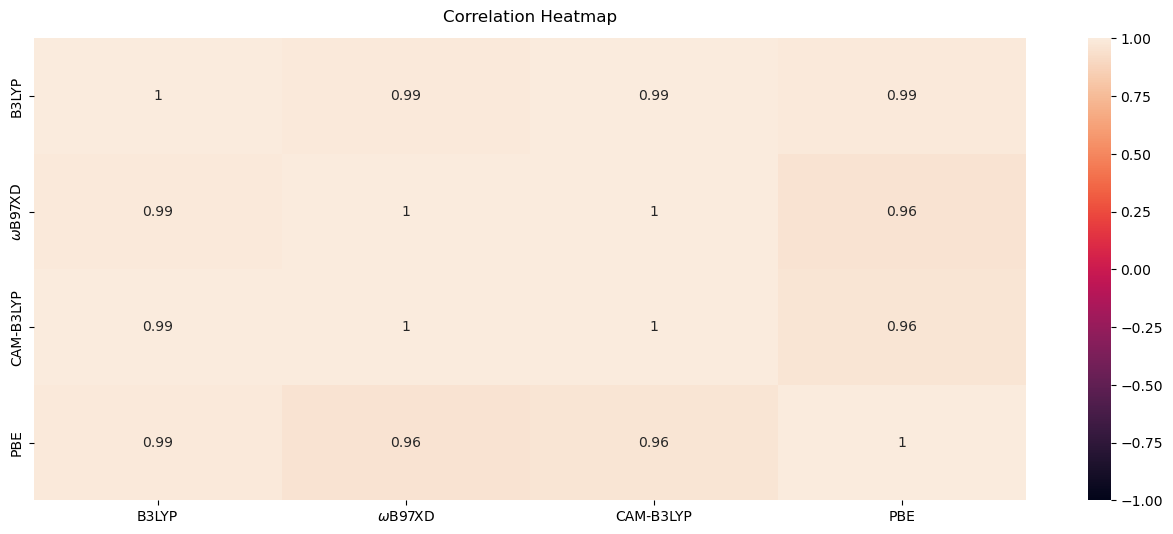

In [15]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(feature.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# Parity plot

In [82]:

def linear_fit(data, x_property, y_property, x_label, y_label):
    Y = data[y_property]
    X = data[[x_property]]

    model = LinearRegression()
    model.fit(X,Y)
    a  = model.intercept_ #截距 
    b = model.coef_ #回归系数
    score = model.score(X,Y)

    Y_pred = model.predict(X)
    xmin = X.min()
    xmax = X.max()

    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    plt.plot((xmin,xmax), (xmin*b[0]+a,xmax*b[0]+a), ls='--', c='black', linewidth=3, label=f"$R^2$={round(score,3)}")
    plt.legend(fontsize=32)

    plt.scatter(X, Y)

    ax.tick_params(direction='in', width=2)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_major_locator(MaxNLocator(4))
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    plt.xlabel(x_label, fontsize=38, font="arial", labelpad=10)
    plt.ylabel(y_label, fontsize=38, font="arial", labelpad=10)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
    plt.gca().tick_params(axis='both', length=10, width=2)


    plt.show()

In [83]:
xc_func_list = ['B3LYP', '$\omega$B97XD', 'CAM-B3LYP', 'PBE']
label_list = ['$E_{gap}^{B3LYP}$ (eV)', 
              '$E_{gap}^{\omega B97XD}$ (eV)', 
              '$E_{gap}^{CAM-B3LYP}$ (eV)', 
              '$E_{gap}^{PBE}$ (eV)']

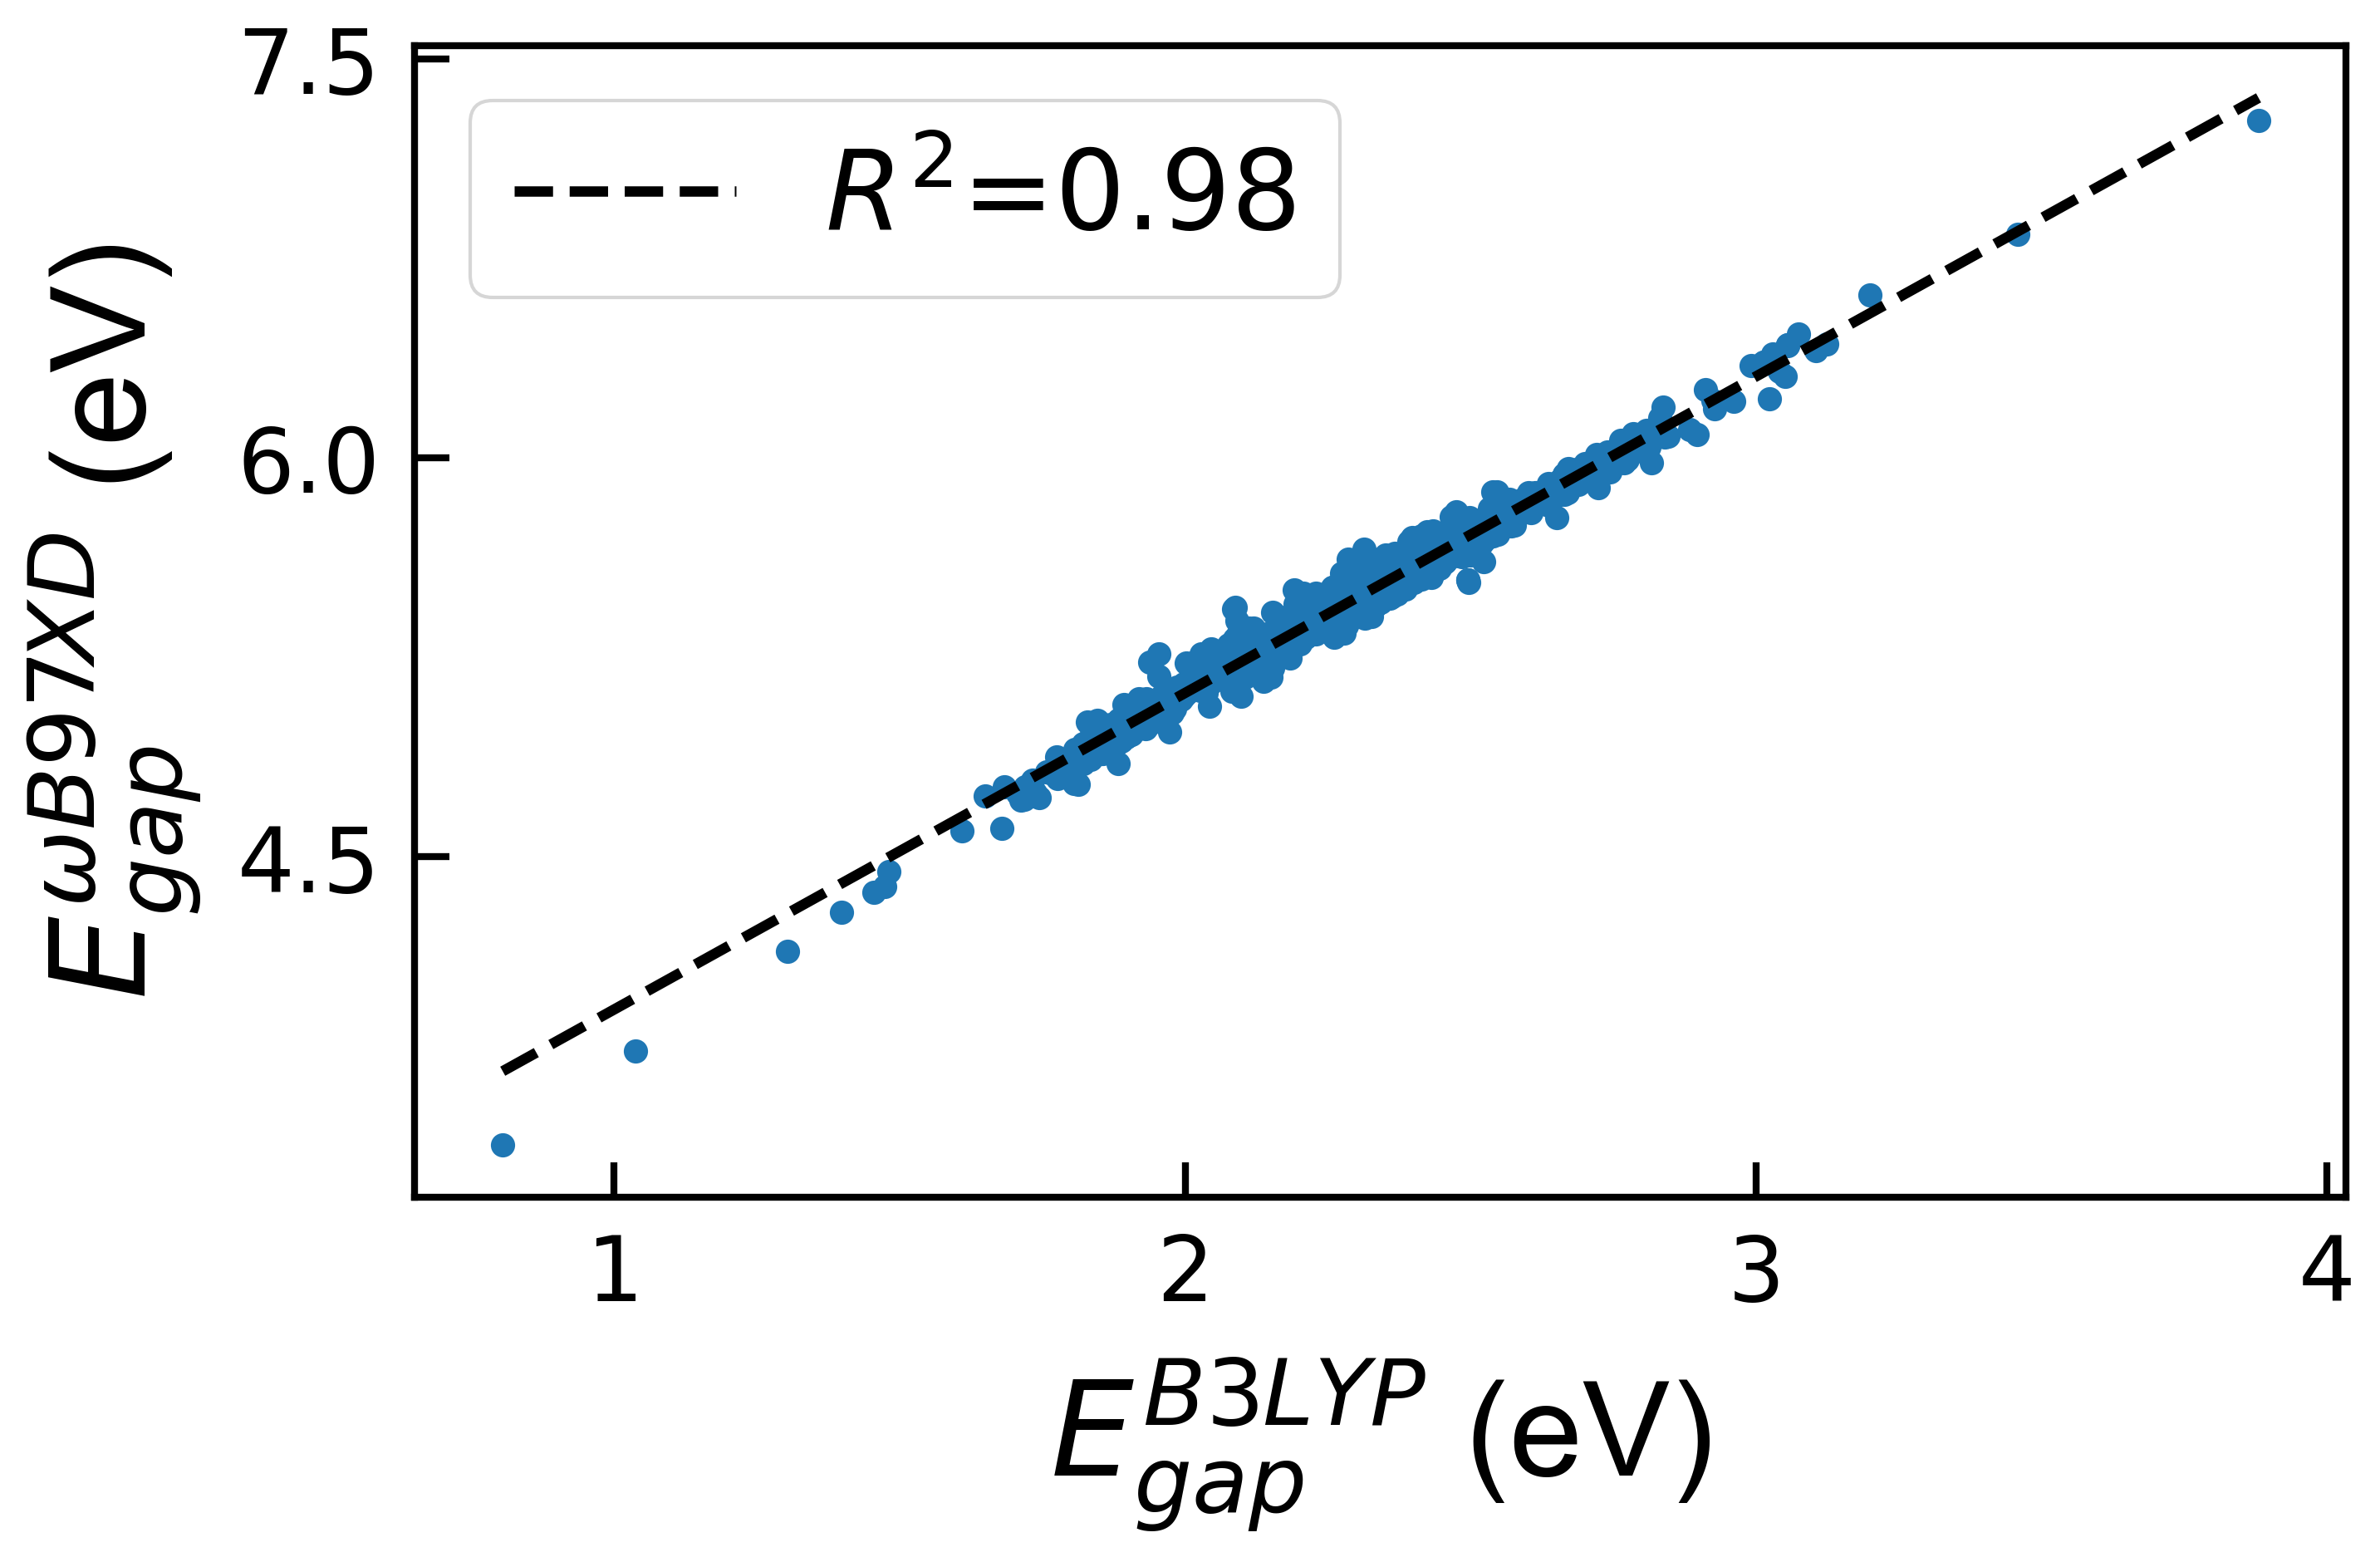

In [84]:
x_idx=0
y_idx=1
linear_fit(feature, xc_func_list[x_idx], xc_func_list[y_idx], label_list[x_idx], label_list[y_idx])

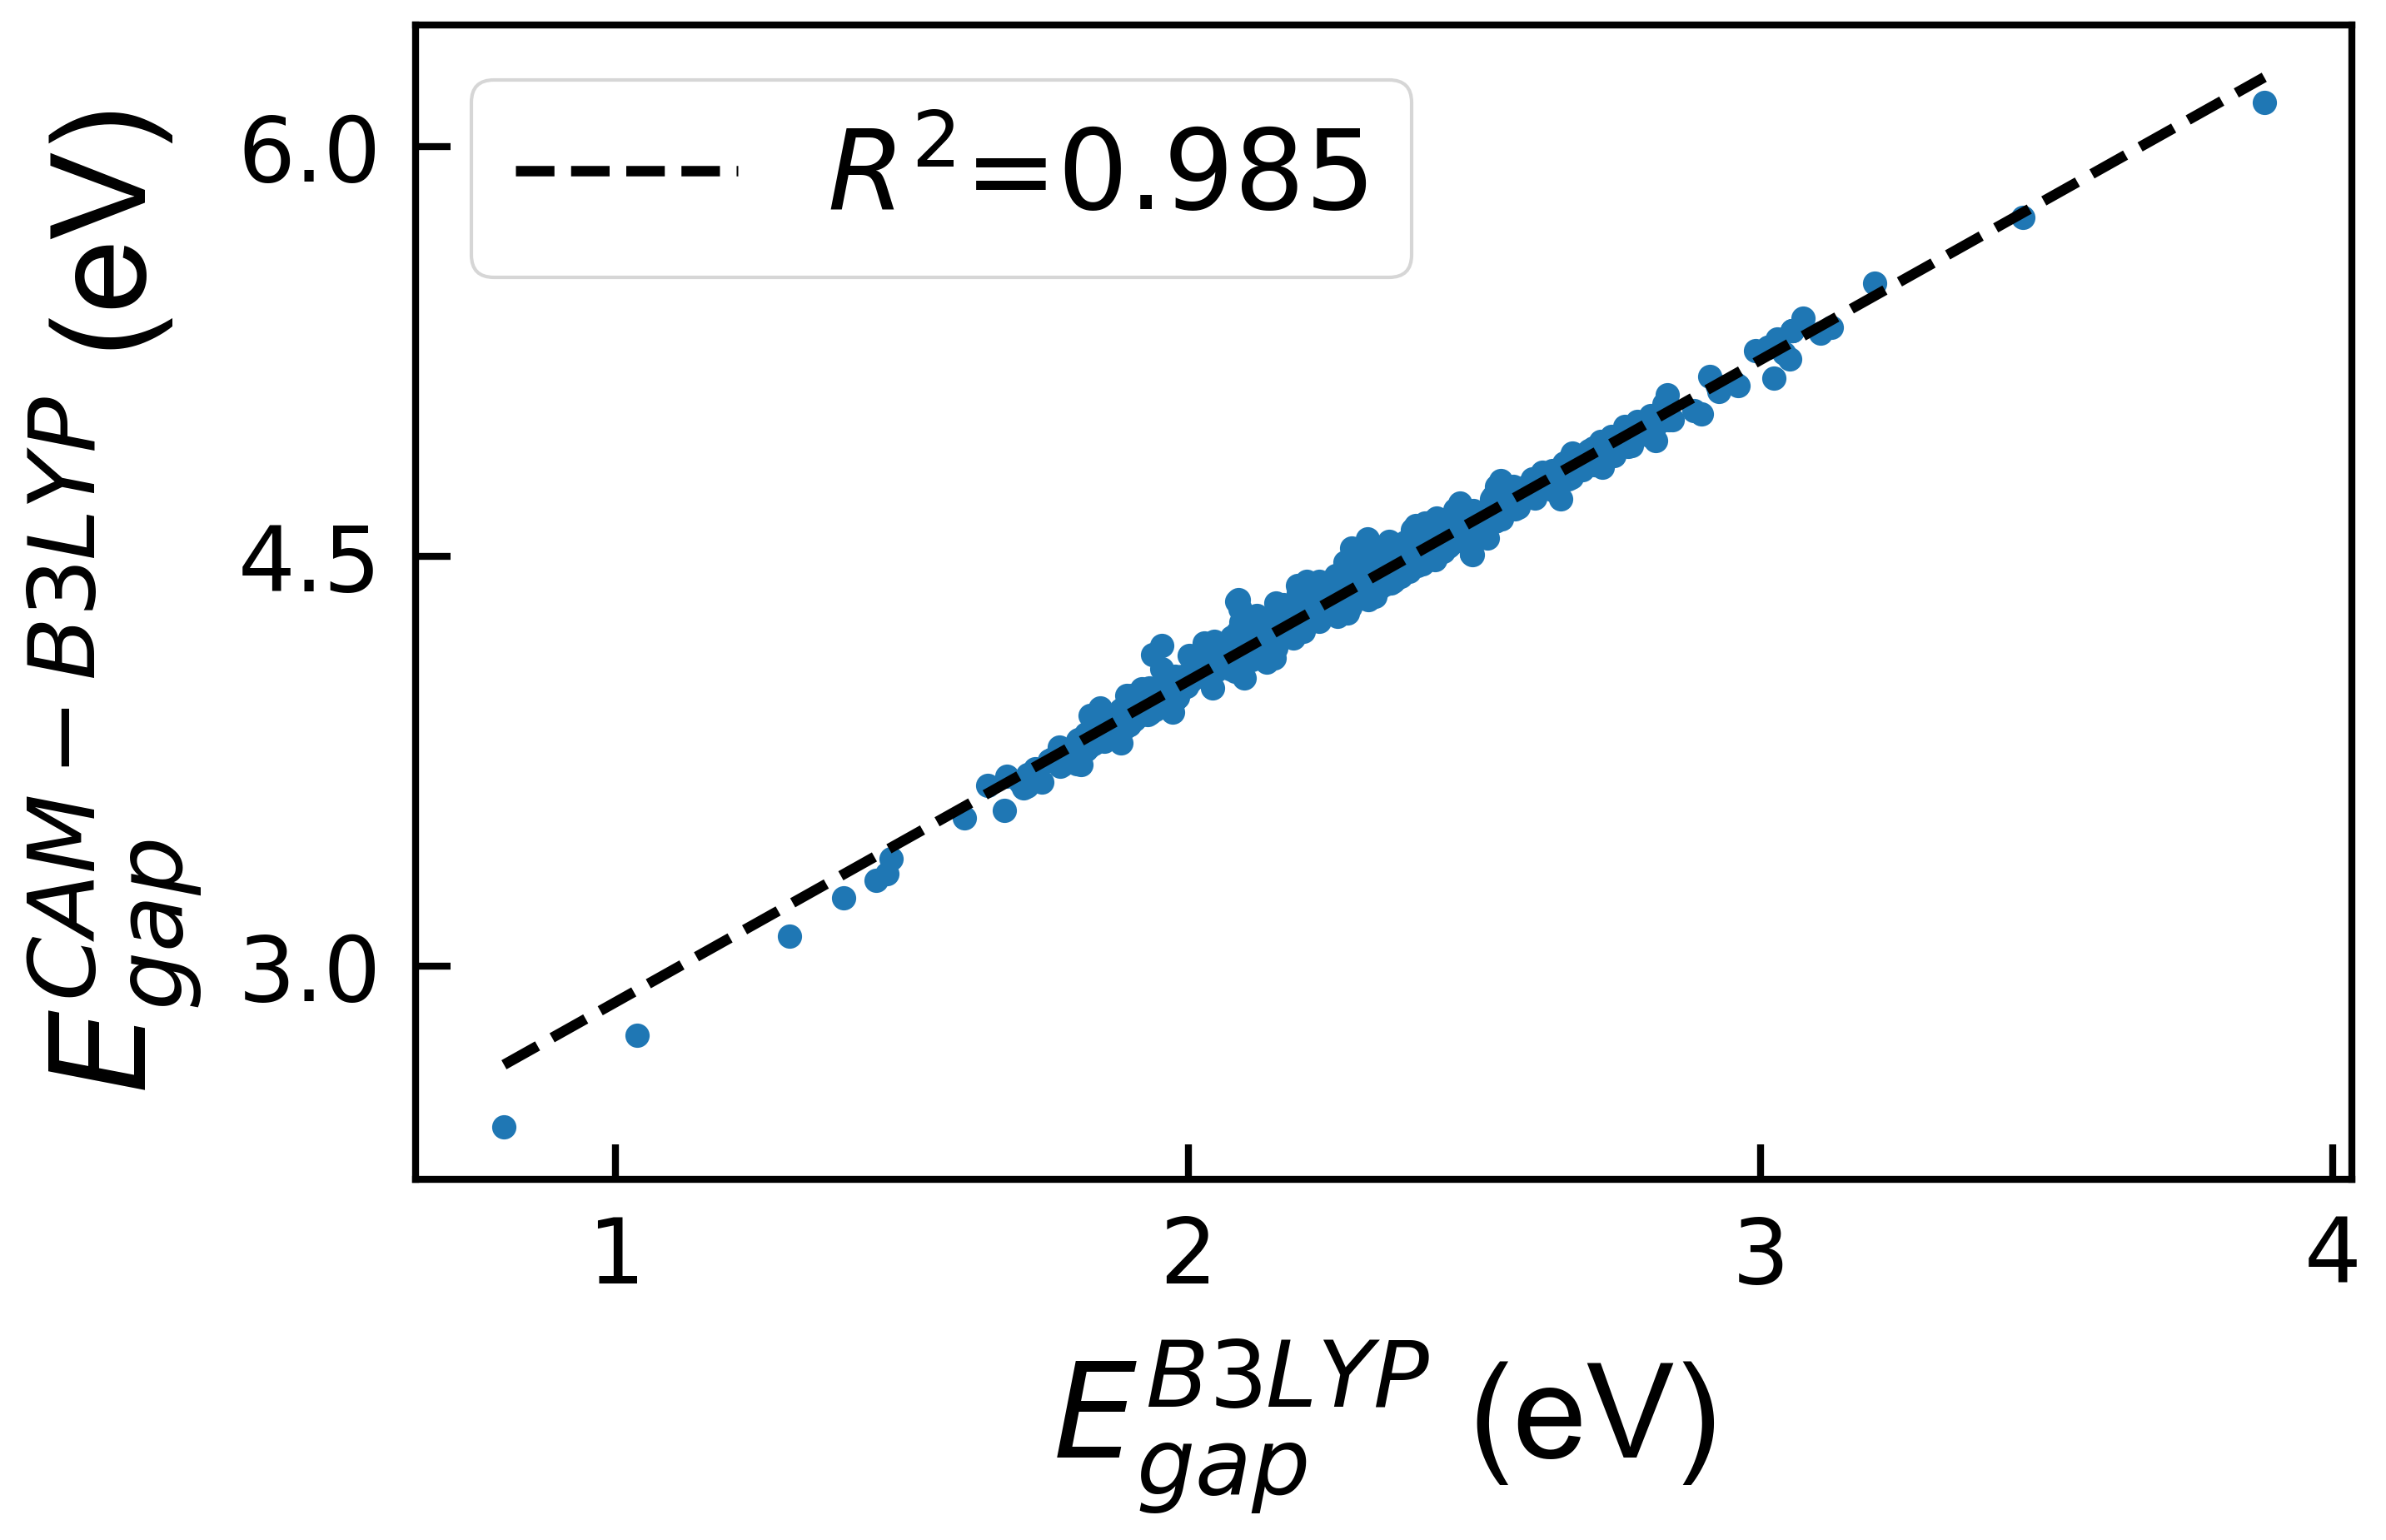

In [85]:
x_idx=0
y_idx=2
linear_fit(feature, xc_func_list[x_idx], xc_func_list[y_idx], label_list[x_idx], label_list[y_idx])

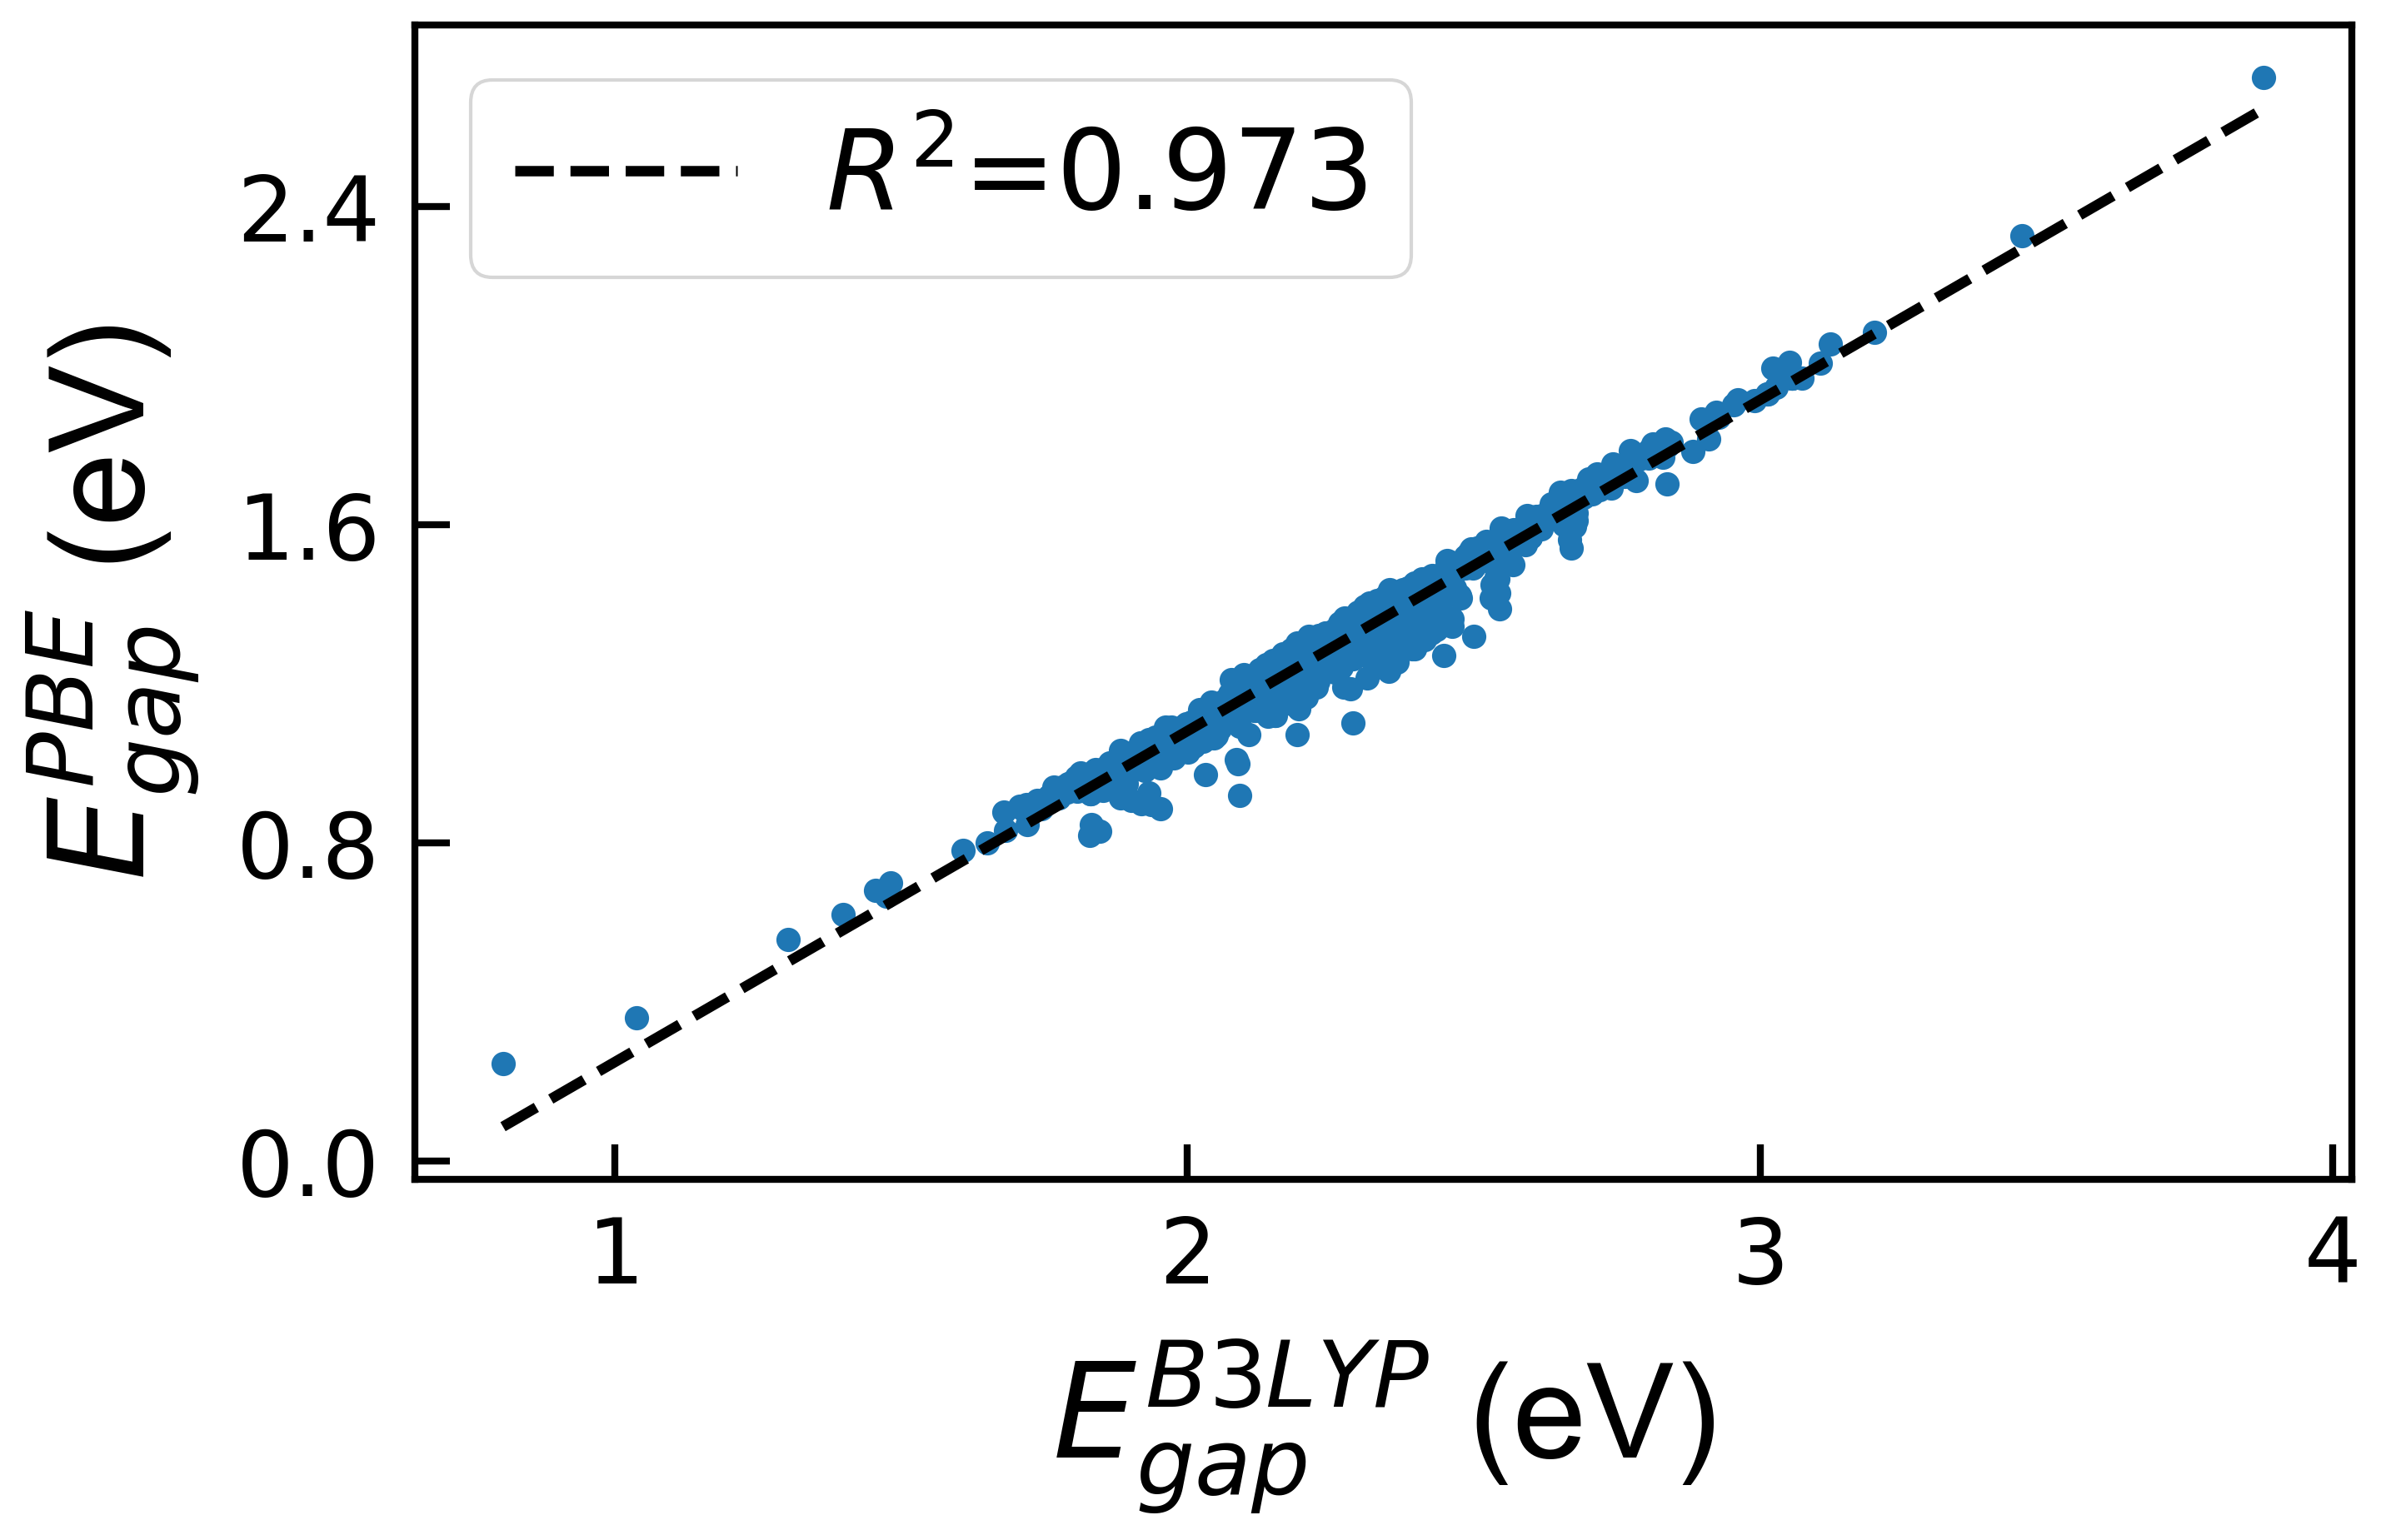

In [86]:
x_idx=0
y_idx=3
linear_fit(feature, xc_func_list[x_idx], xc_func_list[y_idx], label_list[x_idx], label_list[y_idx])

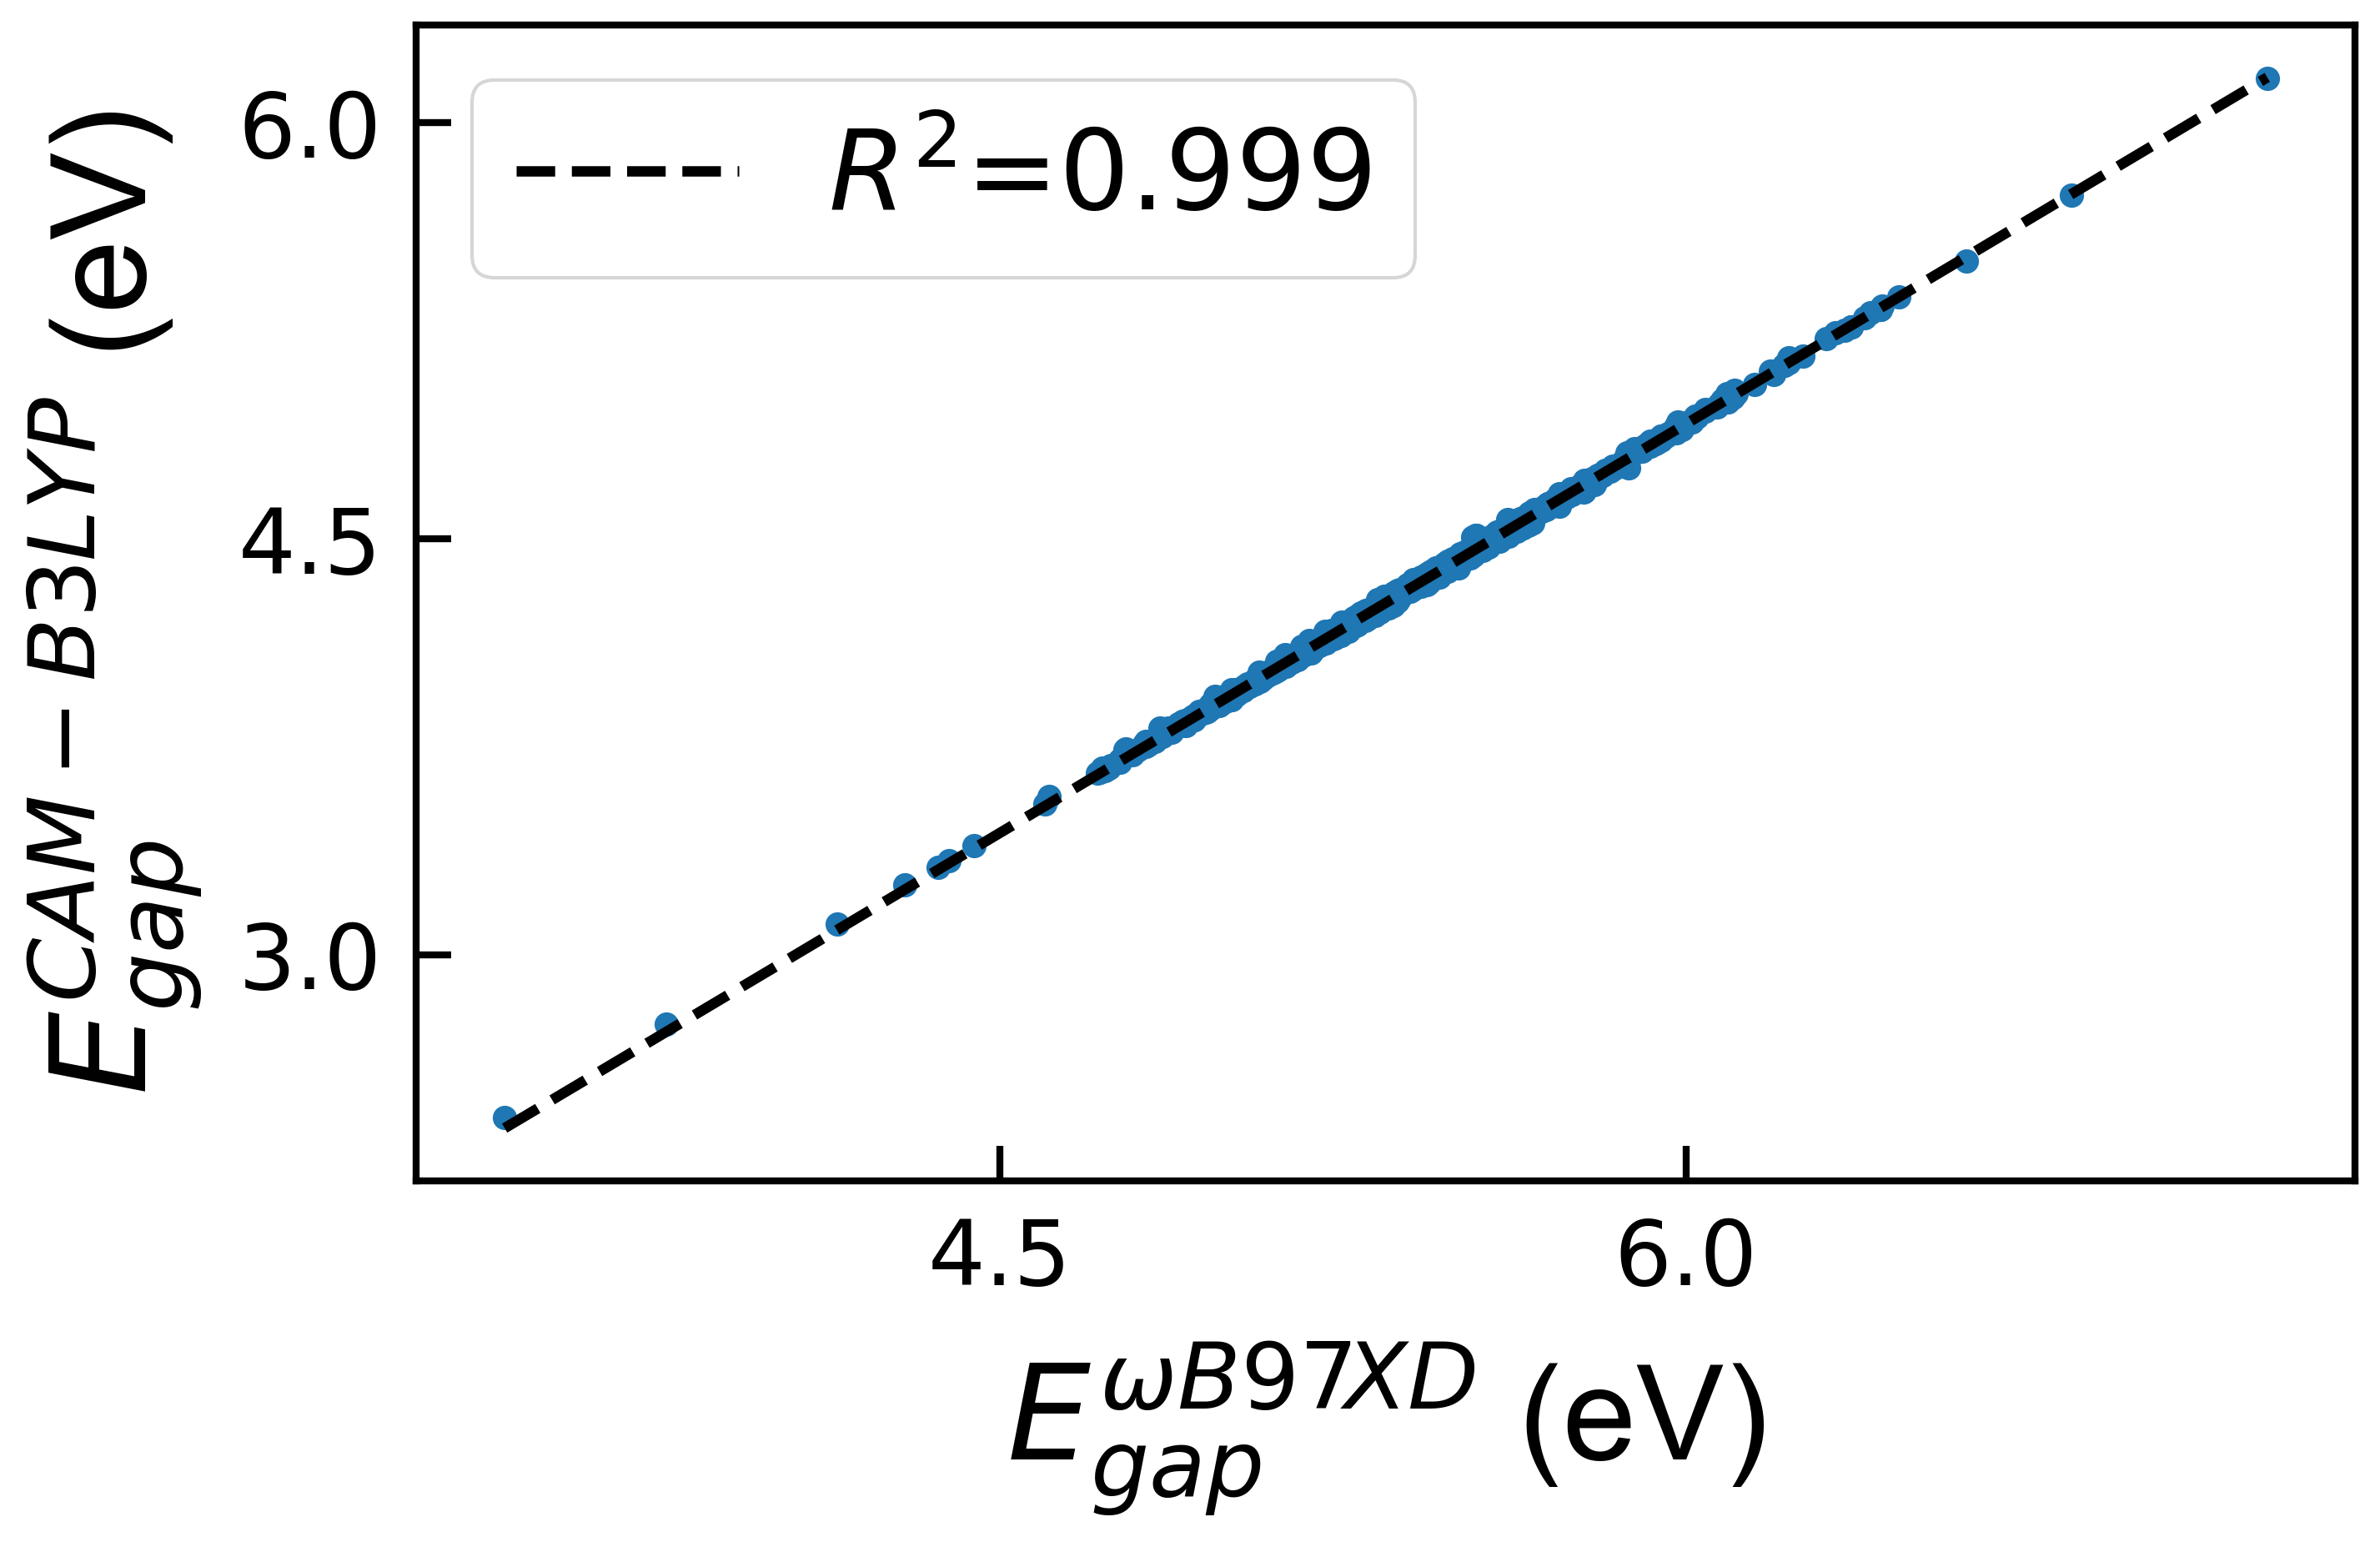

In [87]:
x_idx=1
y_idx=2
linear_fit(feature, xc_func_list[x_idx], xc_func_list[y_idx], label_list[x_idx], label_list[y_idx])

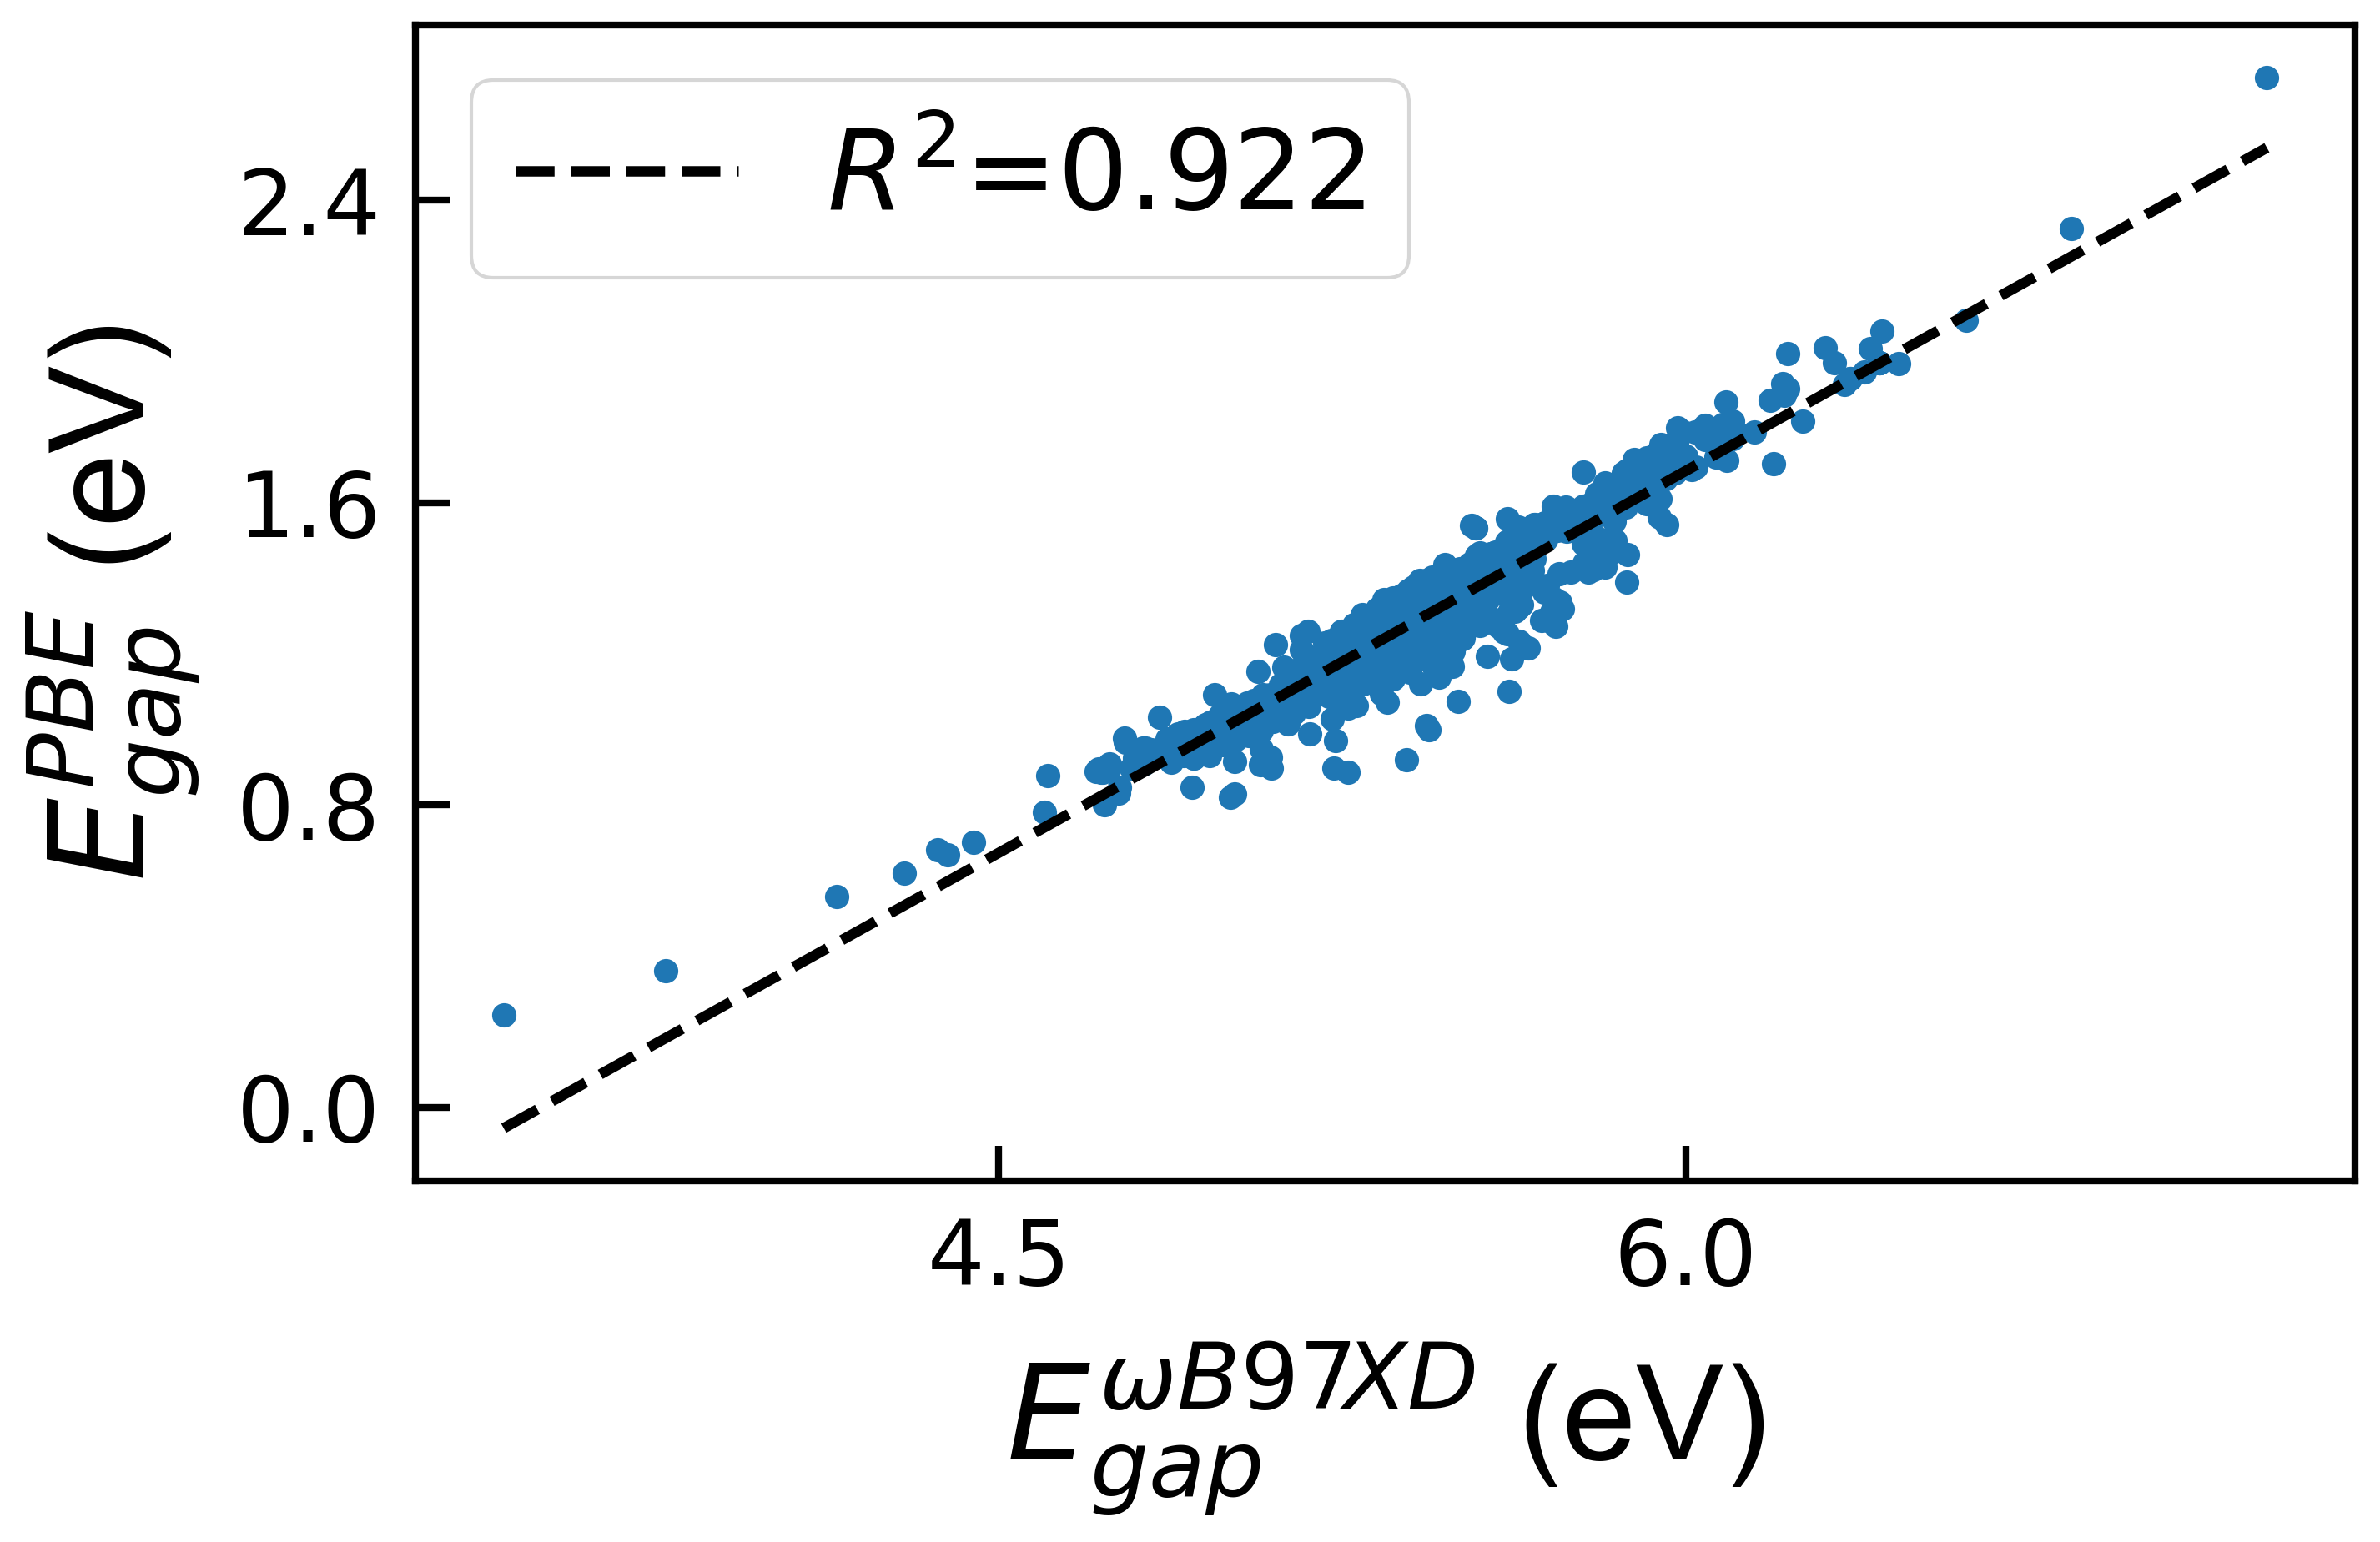

In [88]:
x_idx=1
y_idx=3
linear_fit(feature, xc_func_list[x_idx], xc_func_list[y_idx], label_list[x_idx], label_list[y_idx])

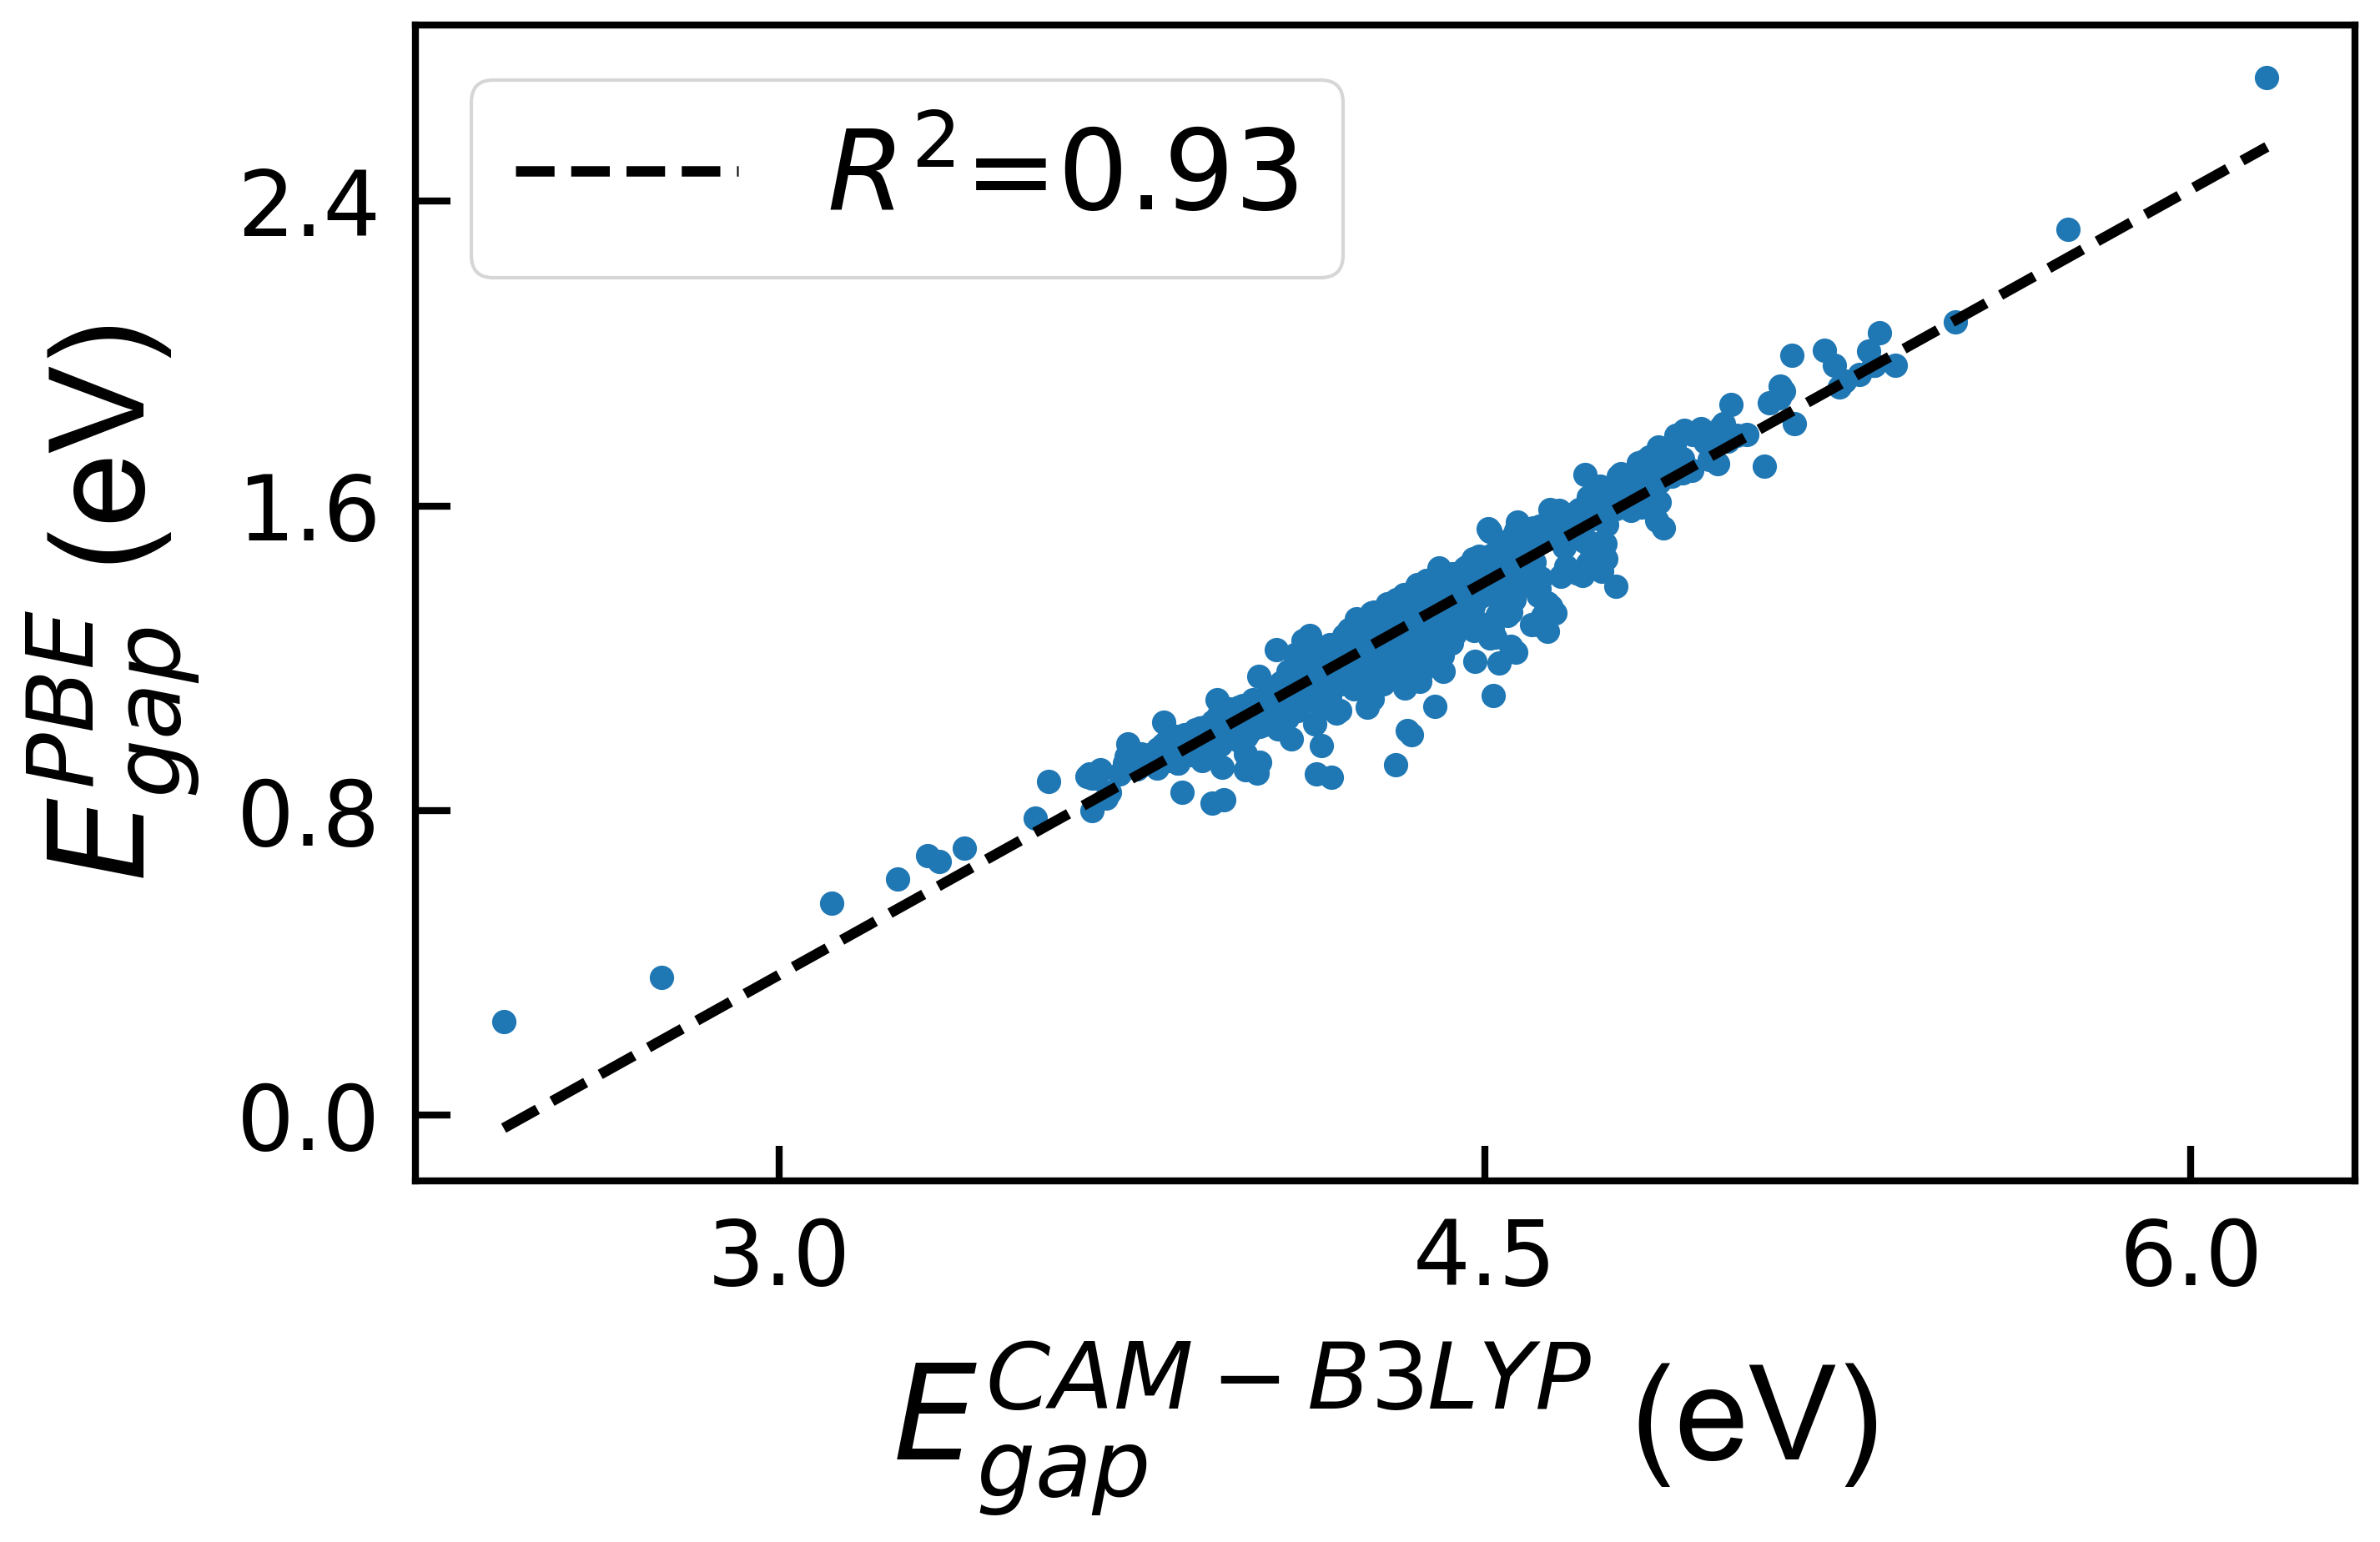

In [89]:
x_idx=2
y_idx=3
linear_fit(feature, xc_func_list[x_idx], xc_func_list[y_idx], label_list[x_idx], label_list[y_idx])

In [90]:
feature

,B3LYP,$\omega$B97XD,CAM-B3LYP,PBE
0,2.78726,6.07168,4.98376,1.76303
1,2.72032,6.01263,4.92009,1.68792
2,3.19979,6.61237,5.50024,2.08358
3,2.69964,5.97943,4.88798,1.68302
4,2.66372,5.93861,4.84880,1.65500
...,...,...,...,...
1091,1.93038,5.04254,3.97123,1.02424
1092,1.93065,5.03302,3.95354,1.03757
1093,2.04439,5.21343,4.12334,1.11594
1094,1.94561,5.03547,3.96361,1.04383


# Linear fitting

In [93]:
y = df_exp
y

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1091    1.68
1092    1.65
1093    1.66
1094    1.52
1095    1.73
Name: bandgap(eV), Length: 1096, dtype: float64

## a. metrics

In [105]:
def acc(y_test,y_pred):
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = MSE ** 0.5
    R2 = r2_score(y_test,y_pred)
#     p = pearsonr(y_test,y_pred.reshape(-1,1)) # y_pred shape = (xxx,)
    r, p_value = pearsonr(y_test,y_pred) # y_pred shape = (xxx,)
    MAE = mean_absolute_error(y_test,y_pred)
    return RMSE, R2, r, MAE

In [108]:
xc_func_list = ['B3LYP', '$\omega$B97XD', 'CAM-B3LYP', 'PBE']
scores = []

for func in xc_func_list:
    X=feature[[func]]

    model = LinearRegression()
    model.fit(X,y)
    y_pred = model.predict(X)

    RMSE, R2, r, MAE = acc(y,y_pred)
    scores.append([RMSE, R2, r, MAE])

scores_df = pd.DataFrame(scores, columns = ['RMSE', 'R2', 'r', 'MAE'])
scores_df.index = xc_func_list
scores_df.round(3)


,RMSE,R2,r,MAE
B3LYP,0.144,0.512,0.716,0.111
$\omega$B97XD,0.141,0.532,0.729,0.108
CAM-B3LYP,0.141,0.528,0.727,0.109
PBE,0.146,0.498,0.706,0.111


In [109]:
# scores_df.round(3).to_csv('xc-functional-linear-fit-metrics.csv')